# Binary Planet Suppression: Filtering

In [21]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import pickle
import pandas as pd

# my preferred settings
mpl.rc('lines',linewidth = 1.5)
mpl.rc('font',size = 14)
mpl.rc('axes',labelsize = 16, linewidth=1.25)
mpl.rc('xtick',labelsize = 16)
mpl.rc('ytick',labelsize = 16)
# enable math fonts
mpl.rc('mathtext', default = 'regular')

from sbin.sbin import suppression_factor, suppression_factor_simple, suppression_simulation
from sbin import parameters

## Read in the data

### Data from Sullivan, Gaia/Bedell, KOIs, KIC

In [2]:
# read in Kendall's catalog, xmatched to all the stuff from Kepler that I need
with open('kendall+kepler.pkl', 'rb') as file:
       db = pickle.load(file)

# read in my kois table
with open('kois+gaia.pkl', 'rb') as file:
        kois = pd.read_pickle(file)

# remove the studied binaries from the all_KOI catalog
kois_less = kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']=='CONFIRMED') & \
                 np.isfinite(kois['parallax']) & \
                 (kois['ruwe']<1.2) ]

print('KOIs, all', len(kois[ (~kois['kepoi_name'].isin(db['kepoi_name'])) & \
                 (kois['koi_disposition']=='CONFIRMED')]) )
print('KOIs, singles', len(kois_less))
print('Binaries, all planets', len(db))
print('Binaries, unique stars', len(db['KOI'].unique()))

KOIs, all 2504
KOIs, singles 2404
Binaries, all planets 404
Binaries, unique stars 286


### CKS Sample

In [3]:
tmp = Table.read('fulton2018.vot')
cks = tmp.to_pandas()
cks['kepoi_name'] = cks['KOI']
cks['KOI'] = cks['kepoi_name'].str.extract(r'K0*(\d+)\.\d+')[0].astype(int)


## Review sample properties

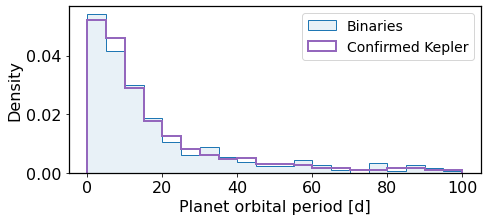

In [4]:
nbins = 20
histrange = (0,100)
fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

plt.hist(db['koi_period'], label='Binaries',
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')

# compared to the kois that are at least not definite binaries with good radii and per<100 days
plt.hist(kois_less['koi_period'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='Confirmed Kepler')

plt.ylabel('Density')
plt.xlabel('Planet orbital period [d]')
plt.legend()
plt.tight_layout()
plt.savefig('periods.png')

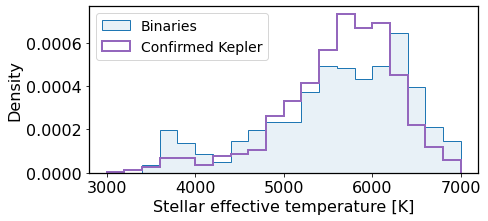

In [5]:
nbins = 20
histrange = (3000,7000)
fig, axes = plt.subplots(1, 1, figsize=(7,3.3), sharex=True, sharey=True)

plt.hist(db['Teff1'], label='Binaries',
             range=histrange, bins=nbins, density=True, 
             histtype='stepfilled',  edgecolor='#1f77b4', facecolor='#e8f1f7')

# compared to the kois that are at least not definite binaries with good radii and per<100 days
plt.hist(kois['teff'], 
             range=histrange, bins=nbins, density=True, 
             histtype='step', lw=2, color='C4',
        label='Confirmed Kepler')

plt.ylabel('Density')
plt.xlabel('Stellar effective temperature [K]')
plt.legend(loc='upper left')
plt.tight_layout()
plt.savefig('steff.png')

In [6]:
lum = (db['Teff1'].astype(float))**4 * db['Rstar1']**2
db['Mass1'] = lum**0.25
lum = (db['Teff2'].astype(float))**4 * (db['Rstar2_Rstar1']*db['Rstar1'])**2
db['Mass2'] = lum**0.25

q = db['Mass1']/db['Mass2']
RL = 0.49*q**(2/3)/(0.6*q**(2/3)+np.log(1+q**(1/3))) # verified against https://dev.adsabs.harvard.edu/scan/
disk = RL * db['SepAU']

db['DiskAU'] = disk

db['SnowAU'] = 0.00465*0.5*(db['Teff1']/170.)**2 # for T_eq = 170K

## Define subsamples

In [20]:
# period and stellar limits
plim = (db['koi_period'] < 100) #& (db['Teff1']<6200) & (db['Teff1']>4000)
kplim = (kois_less['koi_period'] < 100) #& (kois_less['teff']<6200) & (kois_less['teff']>4000)
cksplim = cks['Per'] < 100

# filter the binaries
db_filtered = db[(db['Rppri'] < parameters.radius_limit) & (db['Rppri'] >=0.5) & plim].copy()
close = db_filtered['SepAU']<200
good = db_filtered['e_Rpkep']/db_filtered['Rpkep'] < parameters.max_radius_error

# filter the KOIs
kois_filtered = kois_less[(kois_less['koi_prad']<parameters.radius_limit)
                     & (kois_less['koi_prad'] >= 0.5) & kplim].copy()
kois_good = (kois_less['koi_prad_err1'] - kois_less['koi_prad_err2'])/2. < parameters.max_radius_error

# Filter CKS
cks_filtered = cks[(cks['Rp']<parameters.radius_limit) & (cks['Rp']>=0.5) & cksplim].copy()



In [8]:
bundle = {
    "db_filtered": db_filtered,
    "close": close,                  # boolean Series
    "good": good,                    # boolean Series
    "kois_filtered": kois_filtered,
    "kois_good": kois_good,          # boolean Series
    "cks_filtered": cks_filtered,
}

with open("filtered_data.pkl", "wb") as f:
    pickle.dump(bundle, f, protocol=pickle.HIGHEST_PROTOCOL)


## Get numbers for paper

In [9]:
def calc_statistics(catalog, prad_col = 'Rp', star_col='KOI', MTPS=False):
    
    n_planets = float(len(catalog))
    print( "Number of planets: ", int(n_planets))
    print( "Number of stars: ", len(catalog[star_col].unique()))
    
    n_SEs = float(len(catalog.loc[catalog[prad_col]<parameters.radius_valley]))
    print("Frac super-Earths/n_planets: ", n_SEs/n_planets, "+-", np.sqrt(n_SEs)/n_planets)
    
    if MTPS:
        planet_counts = catalog.groupby(star_col).size().reset_index(name='n_planets')
        stps = len(planet_counts.loc[planet_counts['n_planets']==1])
        mtps = len(planet_counts.loc[planet_counts['n_planets']>1])
        print("Frac MTPS: ", mtps, stps, mtps/(stps+mtps), "+-", np.sqrt(mtps)/(stps+mtps))


# ----------------------------------------------
# Print all the samples and sub-samples
# ----------------------------------------------

        
print("BINARIES\n\n All")
calc_statistics(db_filtered[good], prad_col='Rppri')

print("\n Close (error good)")
calc_statistics(db_filtered[good & close], prad_col='Rppri')

print("\n Wide (error good)")
calc_statistics(db_filtered[good & ~close], prad_col='Rppri')

print("\n Close (any error)")
calc_statistics(db_filtered[close], prad_col='Rppri', MTPS=True)

print("\n Wide (any error)")
calc_statistics(db_filtered[~close], prad_col='Rppri', MTPS=True)


print("\n\nSINGLE KOIS")
calc_statistics(kois_filtered, prad_col='koi_prad', MTPS=True)
print("\nALL CKS")
calc_statistics(cks_filtered)

BINARIES

 All
Number of planets:  191
Number of stars:  138
Frac super-Earths/n_planets:  0.5130890052356021 +- 0.051829816422050604

 Close (error good)
Number of planets:  108
Number of stars:  79
Frac super-Earths/n_planets:  0.5833333333333334 +- 0.0734930919740164

 Wide (error good)
Number of planets:  83
Number of stars:  59
Frac super-Earths/n_planets:  0.42168674698795183 +- 0.07127806967589899

 Close (any error)
Number of planets:  159
Number of stars:  114
Frac super-Earths/n_planets:  0.5911949685534591 +- 0.0609771051247337
Frac MTPS:  30 84 0.2631578947368421 +- 0.04804583837764615

 Wide (any error)
Number of planets:  176
Number of stars:  135
Frac super-Earths/n_planets:  0.44886363636363635 +- 0.05050110464383857
Frac MTPS:  27 108 0.2 +- 0.03849001794597505


SINGLE KOIS
Number of planets:  2024
Number of stars:  1461
Frac super-Earths/n_planets:  0.3705533596837945 +- 0.013530695590542641
Frac MTPS:  379 1082 0.2594113620807666 +- 0.013325066621445439

ALL CKS
Num

### Investigate trends

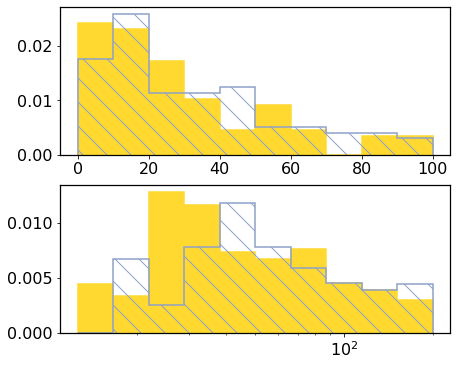

In [29]:
fig, axes = plt.subplots(2, 1, figsize=(7,6), sharex=False, sharey=False)

max_rp = db_filtered.loc[db_filtered.groupby('KOI')['Rppri'].idxmax()].reset_index(drop=True)
db_small = max_rp[max_rp['Rppri']<=parameters.radius_valley].copy()
db_large = max_rp[max_rp['Rppri']>parameters.radius_valley].copy()

    
axes[0].hist(db_large['DiskAU']/db_large['SnowAU'], 
             range=(0,100), histtype='step', density=True,
             edgecolor='#8da0cb', facecolor='#8da0cb', hatch="\\", linewidth=1.5, 
             label='Large planet hosts')
axes[0].hist(db_small['DiskAU']/max_rp['SnowAU'], 
             range=(0,100), hatch='', density=True,
             edgecolor='#ffd92f', facecolor='#ffd92f',  linewidth=1.5,
             label='Small planet hosts')
# how many times bigger is the disk than the snow line


# defining the limits of the semi-major axis
a_values = np.logspace(1.1,2.3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 11)

axes[1].hist(db_large['SepAU'],
             bins=bins, histtype='step', density=True,
             edgecolor='#8da0cb', facecolor='#8da0cb', hatch="\\",  linewidth=1.5, 
             label='Large planet hosts')
axes[1].hist(db_small['SepAU'], 
             bins=bins, density=True,
             edgecolor='#ffd92f', facecolor='#ffd92f',  linewidth=1.5)
axes[1].set_xscale('log') # Set the x-axis to logarithmic scale

plt.show()



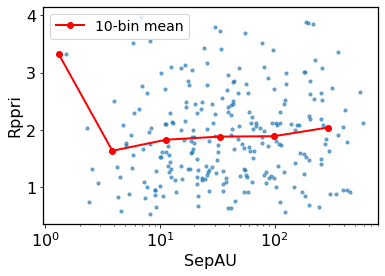

In [11]:
# scatter 
y = max_rp['DiskAU']/max_rp['SnowAU']
plt.scatter(y, max_rp['Rppri'], s=10, alpha=0.6)
plt.xscale('log')
plt.xlabel('SepAU'); plt.ylabel('Rppri')

# 10 log-spaced bins (11 edges)
#bins = np.logspace(np.log10(20), np.log10(3000), 11)
bins = np.logspace(np.log10(0.01), np.log10(500), 11)

# assign points to bins
bin_idx = np.digitize(y.values, bins)

# keep only points inside [bins[0], bins[-1]]
valid = (bin_idx >= 1) & (bin_idx <= len(bins) - 1)
tmp = max_rp.loc[valid, ['Rppri']].copy()
tmp['bin'] = bin_idx[valid]

# mean Rppri per bin, ensure length 10 (fill missing bins with NaN)
means = tmp.groupby('bin')['Rppri'].mean().reindex(range(1, len(bins))).values

# plot at bin centers (geometric mean of edges)
centers = np.sqrt(bins[:-1] * bins[1:])
plt.plot(centers, means, color='red', linewidth=2, marker='o', label='10-bin mean')

plt.legend()
plt.show()

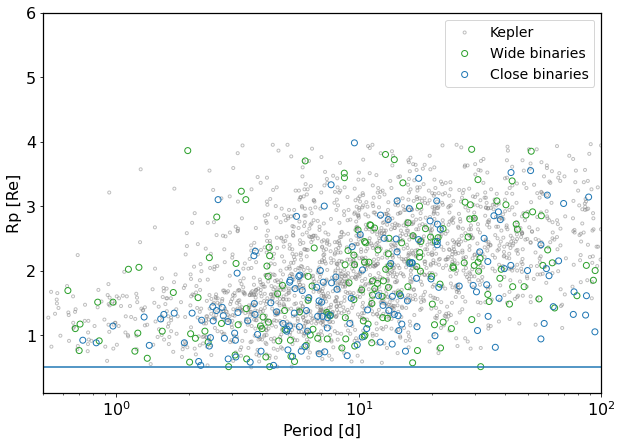

In [12]:
plt.figure(figsize=(10,7))
plt.scatter(kois_filtered['koi_period'], kois_filtered['koi_prad'], marker='.',
         edgecolor='gray', alpha=0.5, lw=1, facecolor='None', label='Kepler')

plt.scatter(db_filtered['koi_period'][~close], db_filtered['Rppri'][~close] ,
         edgecolor='C2', facecolor='None', lw=1, label='Wide binaries')
plt.scatter(db_filtered['koi_period'][close], db_filtered['Rppri'][close] ,
         edgecolor='C0', lw=1, facecolor='None', label='Close binaries')


plt.xlim(0.5,100)
plt.ylim(0.1,6)
plt.axhline(0.5)
plt.xscale('log')
plt.xlabel('Period [d]')
plt.ylabel('Rp [Re]')
plt.legend()

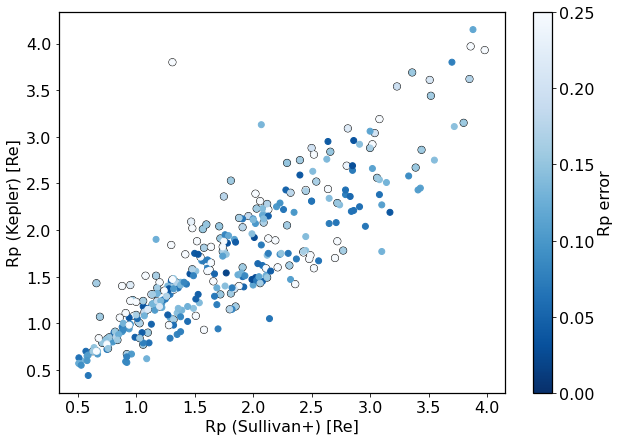

In [13]:
plt.figure(figsize=(10,7))
err = db_filtered['e_Rpkep']/db_filtered['koi_prad']
plt.scatter(db_filtered['Rppri'][err>0.15], db_filtered['koi_prad'][err>0.15], lw=2, edgecolor='k', facecolor='None')
plt.scatter(db_filtered['Rppri'], db_filtered['koi_prad'], c=err, 
            cmap='Blues_r', vmin=0, vmax=0.25)
plt.xlabel('Rp (Sullivan+) [Re]')
plt.ylabel('Rp (Kepler) [Re]')
plt.colorbar(label='Rp error')
plt.show()

# Overview

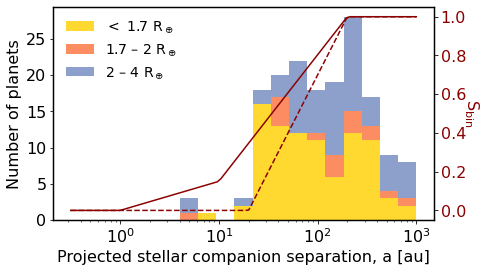

In [32]:
# ----------------------------------------------
# Set-up
# ----------------------------------------------

fig, ax1 = plt.subplots(figsize=(7, 4))

# defining the limits of the semi-major axis
a_values = np.logspace(-0.5,3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 20)

# calculate suppression factors
S_values = suppression_factor(a_values)
S_values2 = suppression_factor_simple(a_values)


# ----------------------------------------------
# First axis -- histogram of planet radii
# ----------------------------------------------


# define the samples
ses = db_filtered['SepAU'][good & (db['Rppri']<=parameters.radius_valley)] # super-Earths
ppp = db_filtered['SepAU'][good & (db['Rppri']>parameters.radius_valley) & (db['Rppri']<2) ] # in-betweens
mns = db_filtered['SepAU'][good & (db['Rppri']>=2) & (db['Rppri']<4) ] # mini-Neptunes

# plot the histograms
ax1.hist([ses, ppp, mns], bins=bins,
         alpha=1, color=['#ffd92f','#fc8d62','#8da0cb'], 
         stacked = True, label=[
                f'$<$ {parameters.radius_valley:.1f} $R_\\oplus$',
                f'{parameters.radius_valley:.1f} – 2 $R_\\oplus$',
                '2 – 4 $R_\\oplus$'])

ax1.set_xscale('log') # Set the x-axis to logarithmic scale
ax1.set_ylabel('Number of planets', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax1.set_xlabel('Projected stellar companion separation, a [au]')
plt.legend(edgecolor='None', facecolor='w')


# ----------------------------------------------
# Second axis -- the suppression equation
# ----------------------------------------------

ax2 = ax1.twinx()

ax2.plot(a_values, S_values, color='darkred', linestyle='-', label='Suppression Factor')
ax2.plot(a_values, S_values2, color='darkred', linestyle='--', label='Suppression Factor')
ax2.tick_params(axis='y', labelcolor='darkred')

ax2.set_ylabel('$S_\mathrm{bin}$', rotation=270, color='darkred', labelpad=15)


# ----------------------------------------------
# Adjust and save
# ----------------------------------------------

plt.xscale('log')
#plt.title('Suppression function from Moe & Kratter')
#plt.grid(True)
plt.tight_layout()
plt.savefig('overview.png')

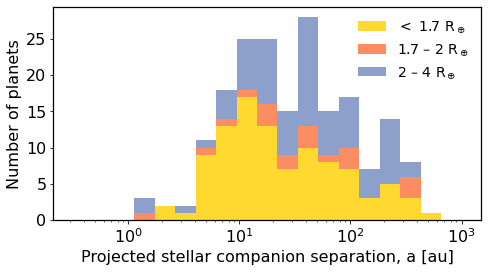

In [28]:
def suppression_factor_simple(a_values):
    a_inner_true = 40  # AU (suppression 100%)
    a_outer_true = 100  # AU (suppression 0%)
    results = (np.log10(a_values) - np.log10(a_inner_true)) / (np.log10(a_outer_true) - np.log10(a_inner_true))
    return np.clip(results, a_min=0, a_max=1)


# ----------------------------------------------
# Set-up
# ----------------------------------------------

fig, ax1 = plt.subplots(figsize=(7, 4))

# defining the limits of the semi-major axis
a_values = np.logspace(-0.5,3, 100)
bins = np.logspace(np.log10(a_values.min()), np.log10(a_values.max()), 20)

# calculate suppression factors
S_values = suppression_factor(a_values)
S_values2 = suppression_factor_simple(a_values)


# ----------------------------------------------
# First axis -- histogram of planet radii
# ----------------------------------------------



# define the samples
ses = (db_filtered['DiskAU']/db_filtered['SnowAU'])[good & (db['Rppri']<=parameters.radius_valley)] # super-Earths
ppp = (db_filtered['DiskAU']/db_filtered['SnowAU'])[good & (db['Rppri']>parameters.radius_valley) & (db['Rppri']<2) ] # in-betweens
mns = (db_filtered['DiskAU']/db_filtered['SnowAU'])[good & (db['Rppri']>=2) & (db['Rppri']<4) ] # mini-Neptunes

# plot the histograms
ax1.hist([ses, ppp, mns], bins=bins,
         alpha=1, color=['#ffd92f','#fc8d62','#8da0cb'], 
         stacked = True, label=[
                f'$<$ {parameters.radius_valley:.1f} $R_\\oplus$',
                f'{parameters.radius_valley:.1f} – 2 $R_\\oplus$',
                '2 – 4 $R_\\oplus$'])

ax1.set_xscale('log') # Set the x-axis to logarithmic scale
ax1.set_ylabel('Number of planets', color='k')
ax1.tick_params(axis='y', labelcolor='k')

ax1.set_xlabel('Projected stellar companion separation, a [au]')
plt.legend(edgecolor='None', facecolor='w')




# ----------------------------------------------
# Adjust and save
# ----------------------------------------------

plt.xscale('log')
#plt.title('Suppression function from Moe & Kratter')
#plt.grid(True)
plt.tight_layout()
#plt.savefig('overview.png')